In [23]:
using DataFrames
using StatsPlots
using CSV
using FASTX
ENV["COLUMNS"] = 200

200

In [24]:
taxonomy =  DataFrame(CSV.File("taxonomy.csv"))
rename!(taxonomy, Symbol("# prot") => :numprot)

1342×8 DataFrame. Omitted printing of 1 columns
│ Row  │ sample │ Clade                         │ Order          │ Family          │ Species                   │ Tissue Type                                        │ Contamination                   │
│      │ String │ String                        │ String         │ String          │ String                    │ Union{Missing, String}                             │ Union{Missing, String}          │
├──────┼────────┼───────────────────────────────┼────────────────┼─────────────────┼───────────────────────────┼────────────────────────────────────────────────────┼─────────────────────────────────┤
│ 1    │ AALA   │ Basal Eudicots                │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia       │ leaves                                             │ All confirmed to Genus level!   │
│ 2    │ AAXJ   │ Core Eudicots                 │ Caryophyllales │ Chenopodiaceae  │ Atriplex prostrata        │ missing                                            │ missing                         │
│ 3    │ ABCD   │ Mosses                        │ Grimmiales     │ Grimmiaceae     │ Racomitrium elongatum     │ gametophyte                                        │ All confirmed to Species level! │
│ 4    │ ABEH   │ Core Eudicots/Asterids        │ incertae sedis │ Boraginaceae    │ Heliotropium greggii      │ mature leaf                                        │ All confirmed to Family level!  │
│ 5    │ ABIJ   │ Lycophytes                    │ Selaginellales │ Selaginellaceae │ Selaginella lepidophylla  │ Young fronds                                       │ All confirmed to Genus level!   │
│ 6    │ ABSS   │ Magnoliids                    │ Laurales       │ Lauraceae       │ Sassafras albidum         │ young leaves                                       │ Harmless Contamination          │
│ 7    │ ACFP   │ Core Eudicots/Rosids          │ Rosales        │ Urticaceae      │ Boehmeria nivea           │ shoot apex including nascent leaves and woody stem │ All confirmed to Species level! │
│ 8    │ ACRY   │ Green Algae                   │ Volvocales     │ Phacotaceae     │ Pteromonas sp.            │ algal cells                                        │ All confirmed to Genus level!   │
│ 9    │ ACWS   │ Conifers                      │ Pinales        │ Araucariaceae   │ Araucaria sp.             │ Young Leaf                                         │ Harmless Contamination          │
│ 10   │ ACYX   │ Basal Eudicots                │ Ranunculales   │ Papaveraceae    │ Papaver rhoeas            │ leaf                                               │ Harmless Contamination          │
⋮
│ 1332 │ ZSNV   │ Basal Eudicots                │ Ranunculales   │ Papaveraceae    │ Papaver bracteatum        │ root                                               │ All confirmed to Family level!  │
│ 1333 │ ZSSR   │ Core Eudicots/Rosids          │ Fabales        │ Fabaceae        │ Xanthocercis zambesiaca   │ leaf                                               │ All confirmed to Family level!  │
│ 1334 │ ZTHV   │ Mosses                        │ Polytrichales  │ Polytrichaceae  │ Atrichum angustatum       │ Mostly sterile, stem-tips.                         │ Harmless Contamination          │
│ 1335 │ ZTLR   │ Core Eudicots/Rosids          │ Malpighiales   │ Rhizophoraceae  │ Rhizophora mangle         │ leaves                                             │ All confirmed to Genus level!   │
│ 1336 │ ZUHO   │ Basal Eudicots                │ Ranunculales   │ Ranunculaceae   │ Anemone hupehensis        │ leaf                                               │ All confirmed to Family level!  │
│ 1337 │ ZULJ   │ Red Algae                     │ Bangiales      │ Bangiaceae      │ Pyropia yezoensis         │ blades                                             │ Harmless Contamination          │
│ 1338 │ ZUQW   │ Core Eudicots/Rosids          │ Fabales        │ Fabaceae        │ Glycine soja              │ root                                 

In [25]:
unwanted = ["Chromista (Algae)","Red Algae","Glaucophyta (Algae)","Dinophyceae","Euglenozoa"]
clean = filter(row -> row.Clade ∉ unwanted, taxonomy)
clean = filter(row -> row.numprot .>= 10000, clean)
println(nrow(clean))
species = groupby(clean, :Species)

1128


GroupedDataFrame with 894 groups based on key: Species
First Group (1 row): Species = "Meliosma cuneifolia"
│ Row │ sample │ Clade          │ Order    │ Family    │ Species             │ Tissue Type │ Contamination                 │ numprot │
│     │ String │ String         │ String   │ String    │ String              │ String?     │ Union{Missing, String}        │ Int64   │
├─────┼────────┼────────────────┼──────────┼───────────┼─────────────────────┼─────────────┼───────────────────────────────┼─────────┤
│ 1   │ AALA   │ Basal Eudicots │ Sabiales │ Sabiaceae │ Meliosma cuneifolia │ leaves      │ All confirmed to Genus level! │ 17784   │
⋮
Last Group (1 row): Species = "Selaginella stauntoniana"
│ Row │ sample │ Clade      │ Order          │ Family          │ Species                  │ Tissue Type                              │ Contamination          │ numprot │
│     │ String │ String     │ String         │ String          │ String                   │ Union{Missing, String}                   │ Union{Missing, String} │ Int64   │
├─────┼────────┼────────────┼────────────────┼─────────────────┼──────────────────────────┼──────────────────────────────────────────┼────────────────────────┼─────────┤
│ 1   │ ZZOL   │ Lycophytes │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material, and gemmae │ Harmless Contamination │ 15017   │

In [26]:
hits = DataFrame(species = String[], target = String[], tlen = Int[], fullscore = Float64[], domscore = Float64[], hmmfrom = Int[], hmmto = Int[])
foreach(filter(x->endswith(x, ".domt"), readdir("onekp", join = true))) do f
    filename = basename(f)
    sample = first(split(filename, "."))
    if sample ∈ taxonomy.sample
        open(f, "r") do infile
            while !eof(infile)
                line = readline(infile)
                startswith(line, "#") && continue
                cols = split(line," ", keepempty=false)
                push!(hits,[sample, cols[1], parse(Int, cols[3]), parse(Float64, cols[8]), parse(Float64, cols[14]), parse(Int, cols[16]), parse(Int, cols[17])])
            end
        end
    end
end
hits[!,:alen] = hits.hmmto .- hits.hmmfrom
cleanhits = innerjoin(clean, hits, on = :sample => :species)
tophitsbyprotein = combine(sdf -> sdf[argmax(sdf.domscore), :], groupby(cleanhits, [:sample,:target]))
tophitsbysample = combine(sdf -> sdf[argmax(sdf.domscore), :], groupby(tophitsbyprotein, :sample))
tophitsbyspecies = combine(sdf -> sdf[argmax(sdf.domscore), :], groupby(tophitsbysample, :Species))
backgroundhits = antijoin(cleanhits,tophitsbysample, on = [:sample,:target])

554837×15 DataFrame. Omitted printing of 5 columns
│ Row    │ sample │ Clade          │ Order          │ Family          │ Species                  │ Tissue Type                              │ Contamination                 │ numprot │ target │ tlen  │
│        │ String │ String         │ String         │ String          │ String                   │ Union{Missing, String}                   │ Union{Missing, String}        │ Int64   │ String │ Int64 │
├────────┼────────┼────────────────┼────────────────┼─────────────────┼──────────────────────────┼──────────────────────────────────────────┼───────────────────────────────┼─────────┼────────┼───────┤
│ 1      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 6453   │ 455   │
│ 2      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 6453   │ 455   │
│ 3      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 14562  │ 382   │
│ 4      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 14562  │ 382   │
│ 5      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 14958  │ 511   │
│ 6      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 14958  │ 511   │
│ 7      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 14958  │ 511   │
│ 8      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 7097   │ 537   │
│ 9      │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 7097   │ 537   │
│ 10     │ AALA   │ Basal Eudicots │ Sabiales       │ Sabiaceae       │ Meliosma cuneifolia      │ leaves                                   │ All confirmed to Genus level! │ 17784   │ 13815  │ 349   │
⋮
│ 554827 │ ZZOL   │ Lycophytes     │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material, and gemmae │ Harmless Contamination        │ 15017   │ 3186   │ 254   │
│ 554828 │ ZZOL   │ Lycophytes     │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material, and gemmae │ Harmless Contamination        │ 15017   │ 3187   │ 254   │
│ 554829 │ ZZOL   │ Lycophytes     │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material, and gemmae │ Harmless Contamination        │ 15017   │ 5449   │ 128   │
│ 554830 │ ZZOL   │ Lycophytes     │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material, and gemmae │ Harmless Contamination        │ 15017   │ 46461  │ 106   │
│ 554831 │ ZZOL   │ Lycophytes     │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material, and gemmae │ Harmless Contamination        │ 15017   │ 682    │ 104   │
│ 554832 │ ZZOL   │ Lycophytes     │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material, and gemmae │ Harmless Contamination        │ 15017   │ 49469  │ 113   │
│ 554833 │ ZZOL   │ Lycophytes     │ Selaginellales │ Selaginellaceae │ Selaginella stauntoniana │ Sterile and fertile material,

In [27]:
controls = DataFrame(target = String[], tlen = Int[], fullscore = Float64[], domscore = Float64[], hmmfrom = Int[], hmmto = Int[])
open("GUN1s.domt", "r") do infile
    while !eof(infile)
        line = readline(infile)
        startswith(line, "#") && continue
        cols = split(line," ", keepempty=false)
        push!(controls,[cols[1], parse(Int, cols[3]), parse(Float64, cols[8]), parse(Float64, cols[14]), parse(Int, cols[16]), parse(Int, cols[17])])
    end
end
controls[!,:alen] = controls.hmmto .- controls.hmmfrom
controls

89×7 DataFrame
│ Row │ target                          │ tlen  │ fullscore │ domscore │ hmmfrom │ hmmto │ alen  │
│     │ String                          │ Int64 │ Float64   │ Float64  │ Int64   │ Int64 │ Int64 │
├─────┼─────────────────────────────────┼───────┼───────────┼──────────┼─────────┼───────┼───────┤
│ 1   │ XP_010267950                    │ 868   │ 1380.0    │ 1379.8   │ 1       │ 762   │ 761   │
│ 2   │ RVX01505                        │ 905   │ 1374.5    │ 1374.3   │ 1       │ 762   │ 761   │
│ 3   │ TXG63280                        │ 878   │ 1362.8    │ 1362.6   │ 1       │ 762   │ 761   │
│ 4   │ GBYR01007015.1_R_3773064        │ 896   │ 1359.7    │ 1359.5   │ 1       │ 762   │ 761   │
│ 5   │ XP_031274127                    │ 877   │ 1354.8    │ 1354.6   │ 1       │ 762   │ 761   │
│ 6   │ XP_042492464                    │ 859   │ 1352.1    │ 1351.9   │ 1       │ 762   │ 761   │
│ 7   │ XP_007051141                    │ 866   │ 1348.6    │ 1348.4   │ 1       │ 762   │ 761   │
│ 8   │ XP_012082926                    │ 871   │ 1348.5    │ 1348.3   │ 1       │ 762   │ 761   │
│ 9   │ KAF9834297                      │ 878   │ 1348.5    │ 1348.3   │ 1       │ 762   │ 761   │
│ 10  │ GBJU01025666.1_F_12628          │ 876   │ 1347.6    │ 1347.5   │ 1       │ 762   │ 761   │
⋮
│ 79  │ lcl|SM000012S25272              │ 1035  │ 1134.8    │ 59.2     │ 143     │ 214   │ 71    │
│ 80  │ lcl|SM000012S25272              │ 1035  │ 1134.8    │ 370.0    │ 522     │ 762   │ 240   │
│ 81  │ TRINITY_DN49275_c1_g1_i1_ZcGUN1 │ 1211  │ 1119.3    │ 1113.7   │ 1       │ 762   │ 761   │
│ 82  │ GBRQ01001581.1_F_17574117       │ 787   │ 1103.0    │ 666.5    │ 1       │ 472   │ 471   │
│ 83  │ GBRQ01001581.1_F_17574117       │ 787   │ 1103.0    │ 441.1    │ 512     │ 761   │ 249   │
│ 84  │ c110426_g1_i2_R_3592680         │ 774   │ 1098.6    │ 1089.5   │ 1       │ 762   │ 761   │
│ 85  │ GBG71751                        │ 1371  │ 1098.4    │ 1097.8   │ 1       │ 762   │ 761   │
│ 86  │ Nitella                         │ 1194  │ 1089.8    │ 1089.6   │ 1       │ 762   │ 761   │
│ 87  │ XP_024521906                    │ 841   │ 1046.7    │ 663.1    │ 1       │ 472   │ 471   │
│ 88  │ XP_024521906                    │ 841   │ 1046.7    │ 379.4    │ 515     │ 762   │ 247   │
│ 89  │ GHUK01004054.1_R_4383491        │ 1018  │ 1008.2    │ 1004.0   │ 1       │ 761   │ 760   │

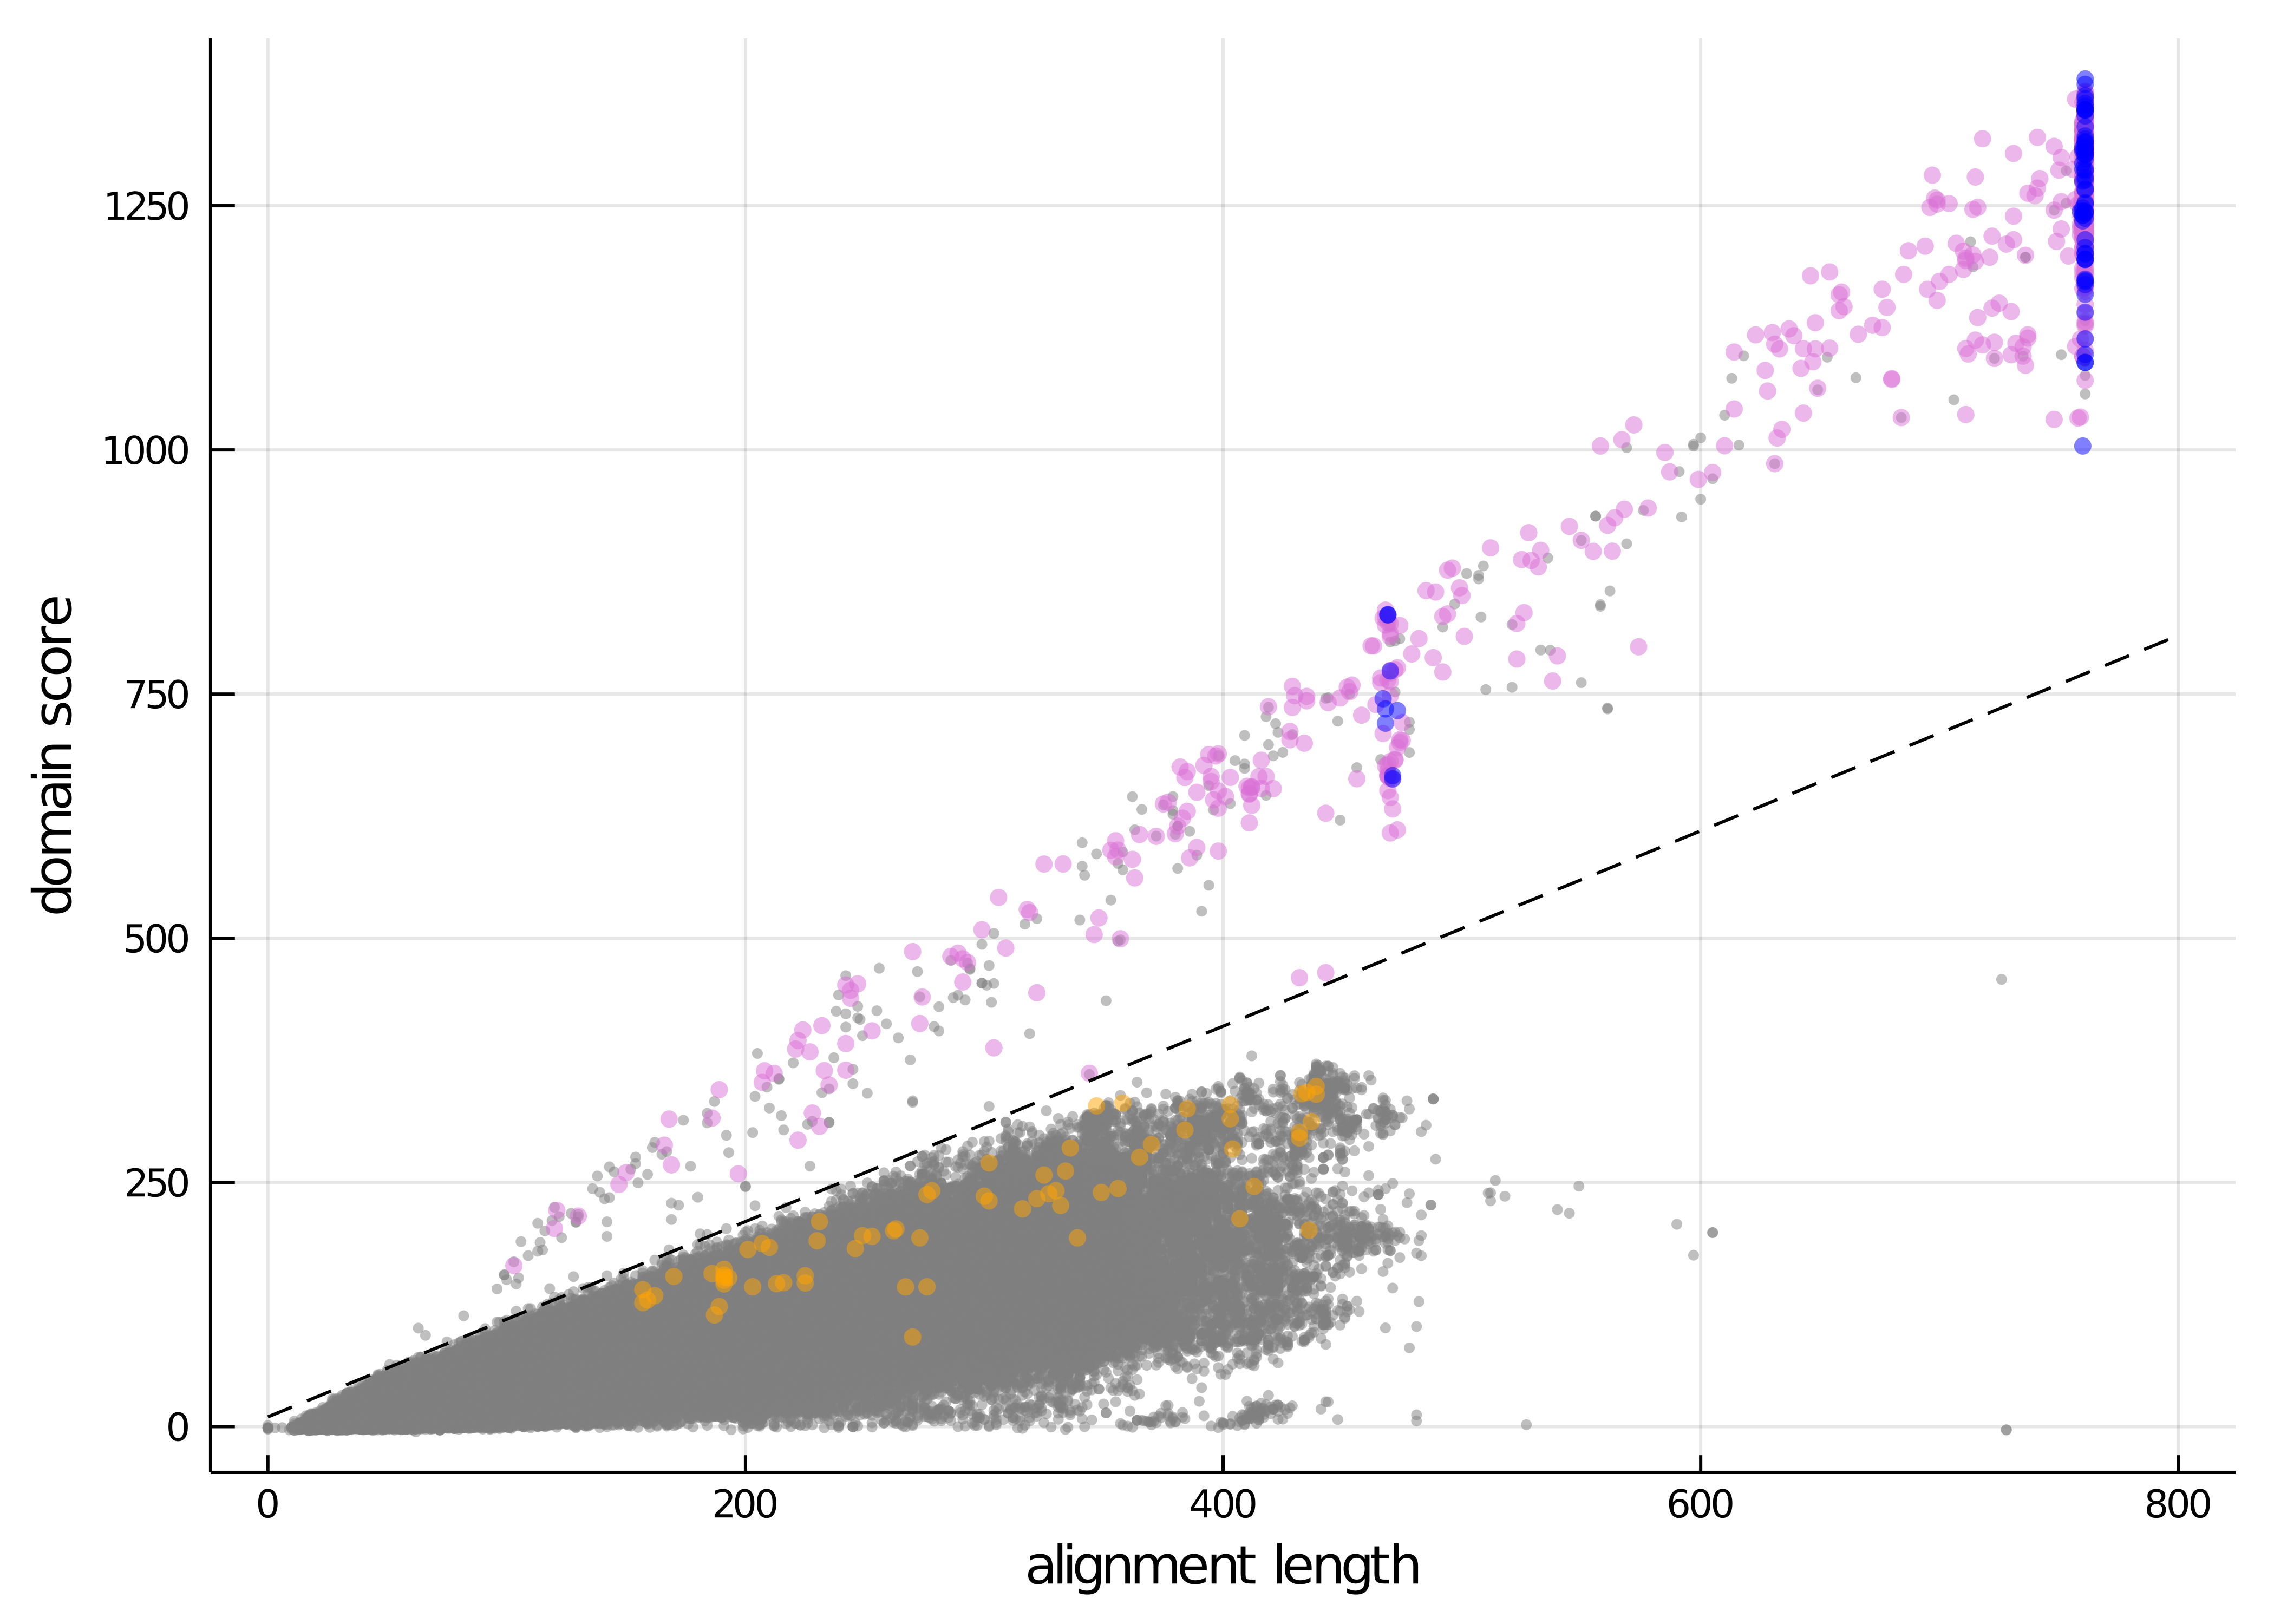

In [28]:
#not GUN1s (except for species with multiple GUN1s due to polyploidy)
@df backgroundhits scatter(:alen, :domscore, fmt=:png, ms=2, msw=0, color=:gray, alpha=0.5)
@df tophitsbyspecies[tophitsbyspecies.domscore .> tophitsbyspecies.alen .+ 10,:] scatter!(:alen, :domscore, fmt=:png, ms=3, msw=0, color=:orchid, alpha=0.5, legend=false)
@df tophitsbyspecies[tophitsbyspecies.domscore .<= tophitsbyspecies.alen .+ 10,:] scatter!(:alen, :domscore, fmt=:png, ms=3, msw=0, color=:orange, alpha=0.5, legend=false)
topcontrols = combine(sdf -> sdf[argmax(sdf.domscore), :], groupby(controls, :target))
@df topcontrols scatter!(:alen, :domscore, fmt=:png, ms=3, msw=0, color=:blue, alpha=0.5, label="+ve controls", xlabel="alignment length", ylabel="domain score", xguidefontfamily="Helvetica Bold", yguidefontfamily="Helvetica Bold")
plot!([0,800],[10,810], color=:black, ls = :dash, size=(1750/2.5,1250/2.5), dpi=600)

In [29]:
savefig("GUN1 classification.png")

In [30]:
tophitsbyspecies.hasGUN1 = tophitsbyspecies.domscore .> tophitsbyspecies.alen .+ 10
CSV.write("TableS2.csv", tophitsbyspecies)

"TableS2.csv"

In [31]:
GUN1s = tophitsbyspecies[tophitsbyspecies.hasGUN1 .== 1,:]
println("number of species with putative GUN1 = ", nrow(GUN1s))
println("number of families = ", length(groupby(cleanhits, :Family)))
println("number of families with putative GUN1 = ", length(groupby(GUN1s, :Family)))

number of species with putative GUN1 = 824
number of families = 366
number of families with putative GUN1 = 345


In [32]:
allfamilies = first.(keys(groupby(cleanhits, :Family)))
familieswithGUN1 = first.(keys(groupby(GUN1s, :Family)))
lackGUN1 = setdiff(allfamilies, familieswithGUN1)

21-element Vector{String}:
 "Chlamydomonadaceae"
 "Ulvaceae"
 "Juglandaceae"
 "Dunaliellaceae"
 "Chlorodendraceae"
 "Aphanochaetaceae"
 "Volvocaceae"
 "Hydrodictyaceae"
 "Haematococcaceae"
 "Goniaceae"
 "Nephroselmidaceae"
 "Oocystaceae"
 "Thelypteridaceae"
 "Agapanthaceae"
 "Pleurastraceae"
 "Actinidiaceae"
 "Hymenophyllaceae"
 "Monocleaceae"
 "Pyramimonadaceae"
 "Carteriaceae"
 "Cyrillaceae"

In [33]:
unique(combine(groupby(filter(row -> row.Family ∈ lackGUN1, taxonomy[!,[:Clade,:Family]]), :Family), :Clade => (x -> unique(x)[1]) => :Clade, :Family => (x -> identity(x)) => :Family))

21×2 DataFrame
│ Row │ Family             │ Clade                         │
│     │ String             │ String                        │
├─────┼────────────────────┼───────────────────────────────┤
│ 1   │ Haematococcaceae   │ Green Algae                   │
│ 2   │ Chlamydomonadaceae │ Green Algae                   │
│ 3   │ Ulvaceae           │ Green Algae                   │
│ 4   │ Chlorodendraceae   │ Green Algae                   │
│ 5   │ Juglandaceae       │ Core Eudicots/Rosids          │
│ 6   │ Dunaliellaceae     │ Green Algae                   │
│ 7   │ Aphanochaetaceae   │ Green Algae                   │
│ 8   │ Nephroselmidaceae  │ Green Algae                   │
│ 9   │ Volvocaceae        │ Green Algae                   │
│ 10  │ Hydrodictyaceae    │ Green Algae                   │
│ 11  │ Goniaceae          │ Green Algae                   │
│ 12  │ Oocystaceae        │ Green Algae                   │
│ 13  │ Thelypteridaceae   │ Leptosporangiate Monilophytes │
│ 14  │ Agapanthaceae      │ Monocots                      │
│ 15  │ Pleurastraceae     │ Green Algae                   │
│ 16  │ Actinidiaceae      │ Core Eudicots/Asterids        │
│ 17  │ Hymenophyllaceae   │ Leptosporangiate Monilophytes │
│ 18  │ Carteriaceae       │ Green Algae                   │
│ 19  │ Monocleaceae       │ Liverworts                    │
│ 20  │ Pyramimonadaceae   │ Green Algae                   │
│ 21  │ Cyrillaceae        │ Core Eudicots/Asterids        │